# Code to plot PSDDF data
### Version 1.2

Date: 08/01/2023

Author: Jonathan Moore


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
import os
import re

## Classes

In [42]:
class PSDDF_run:
    def __init__(self, folder_dir, output_name, units):
        self.folder_dir = PSDDF_run.valid_str_input(folder_dir)
        self.output_name = PSDDF_run.valid_str_input(output_name)
        self.units = PSDDF_run.valid_dict_input(units)

        # Init dict to hold the directories of the files
        self.file_dirs = {"pgc": "", "pgd": "", "psp":""}
    
        # Init dict to hold layer raw file df
        self.file_dfs = {"pgc": "", "pgd": "", "psp":""}

        # Init dict to hold the layer dfs
        self.layer_dfs = {"pgc": "", "pgd": ""}

        # Init dict to hold the layer settlements
        self.layer_settlements = {"pgc": "", "pgd": ""}

        # Init dict to hold the total settlements
        self.tot_settlements = {"pgc": "", "pgd": ""}

        # File type list
        self.file_type_list = ["pgc", "pgd", "psp"]
        
        # Init dict to hold field data
        self.field_data = {"Settlement": ""}

        # Init dict to hold dredge settlement field data
        # self.dredge_field_settlement_data = {"layer": "", "Total":""}

        # # Init dict to hold foundation settlement field data
        # self.foundation_field_settlement_data = {"layer": "", "Total":""}

        # # Init dict to hold total settlement field data
        # self.total_settlement_data = {}

    def __repr__(self):
        print("Showing the __repr__")
        return "Output Dir = {} \nOutput filename = {} \nunits = {}".format(self.folder_dir, self.output_name, self.units)
    
    @staticmethod
    def valid_str_input(input_str):
        if isinstance(input_str, str):
            return input_str
        else:
            raise TypeError("Input must be a string. Type is {}".format(type(input_str)))
        
    @staticmethod
    def valid_int_input(input_int):
        if isinstance(input_int, int):
            return input_int
        else:
            raise TypeError("Input must be an int. Type is {}".format(type(input_int)))
    
    @staticmethod
    def valid_list_input(input_list):
        if isinstance(input_list, list):
            return input_list
        else:
            raise TypeError("Input must be a list. Type is {}".format(type(input_list)))
        
    @staticmethod
    def valid_df_input(input_df):
        if isinstance(input_df, pd.DataFrame):
            return input_df
        else:
            raise TypeError("Input must be a dataframe. Type is {}".format(type(input_df)))
    
    @staticmethod
    def valid_dict_input(input_dict):
        if isinstance(input_dict, dict):
            return input_dict
        else:
            raise TypeError("Input must be a dictionary. Type is {}".format(type(input_dict)))

    @staticmethod
    def valid_bool_input(input_bool):
        if isinstance(input_bool, bool):
            return input_bool
        else:
            raise TypeError("Input must be a boolean. Type is {}".format(type(input_bool)))

    @staticmethod
    def valid_file_type(file_type, file_type_list):
        ## Purpose check that the file_type is a string and that it is an acceptable file type
       
        #Check if the input is a string
        file_type = PSDDF_run.valid_str_input(file_type)
        
        # Check if input is list
        file_type_list = PSDDF_run.valid_list_input(file_type_list)

        #Check if the entered file type is an allowable file type
        if file_type in file_type_list:
            # If yes return the file type
            return file_type
        else:
            # If not, throw type error
            raise TypeError("File type must be one of: {}".format(file_type_list))
    
    @staticmethod
    def valid_file(file_dir):
        if os.path.isfile(file_dir):
            return file_dir
        else:
            raise OSError("File: {} does not exist".format(file_dir))
    
    @staticmethod
    def valid_folder(folder_dir):
        if os.path.exists(folder_dir):
            return folder_dir
        else:
            raise OSError("Folder {} does not exist".format(folder_dir))
    
    @staticmethod
    def check_dir_created(file_dir):
        # Check if a file dir has been created
        if file_dir == "":
            return False
        if type(file_dir) is str:
            return True
        
    @staticmethod
    def check_df_created(supposed_df):
        # Check if
        if isinstance(supposed_df, pd.DataFrame):
            return True
        else:
            return False
    
    @staticmethod
    def check_list_created(supposed_list):
         # Check if
        if isinstance(supposed_list, list):
            return True
        else:
            return False
        
    @staticmethod
    def file_2_lines(file_dir):
        # First check that the file exists
        PSDDF_run.valid_file(file_dir)

        # Read file_dir and convert it to lines
        with open(file_dir, "r") as file:
            lines = file.readlines()
        return lines
    
    @staticmethod
    def lines_2_df(lines):

        # Check that the input is a list
        lines = PSDDF_run.valid_list_input(lines)

        # Init list to hold data
        data = []

        # Read each line in lines 
        for line in lines:

            # Strip spaces
            values = re.split(r"\s+", line.strip())

            # Append the line to the data list
            data.append(values)
        
        #convert data to df
        df = pd.DataFrame(data, dtype = np.float64)
        return df

    @staticmethod
    def check_df_width(df, correct_width):
        ## Purpose: Check the length of a df

        # Check that the input are correct
        df = PSDDF_run.valid_df_input(df)
        correct_width = PSDDF_run.valid_int_input(correct_width)

        # Check length
        if df.shape[1] == correct_width:
            return df
        else:
            raise ValueError("The width of the df is incorrect. It is {} it should be {}".format(df.shape[1], correct_width))
    
    @staticmethod
    def check_columns_in_df(df, columns):
        # Check if the input is a df
        df = PSDDF_run.valid_df_input(df)

        # Check if the input is a list
        columns = PSDDF_run.valid_list_input(columns)

        # Check if the list is a subset of the columns
        # returns True if subset and False if not
        return set(columns).issubset(set(df.columns))

    @staticmethod
    def calc_Xi_coordinate(df):
        # The purpose of this function is to calculate Xi coordinates from Z coordiantes

        # Check if that the input is a df
        df = PSDDF_run.valid_df_input(df)

        # Calc difference between Z coordinate
        dz = df["Z"].diff()

        # Calcualte d_Xi
        d_Xi = (1 + df["e"]) * dz

        # Do a discrete integration
        Xi = d_Xi.cumsum()

        # Set the first value to zero instead of NaN
        Xi.iloc[0] = 0

        return Xi
    
    @staticmethod
    def PGD_df_2_layer_df(df):
        # Init variable to track current row
        row_index = 0

        # Init list to hold each layer df
        layer_df_list = []

        # Init list to hold the PSDDF print times
        PSDDF_print_times_list = []

        # Init list to hold number of sublayers
        num_sublayers_list = [0]

        # Get length of df
        len_df = df.shape[0]

        # Init int to hold the number of sublayers in the current layer
        current_num_sublayers = 0

        # init int to hold the number of sublayers in the previous layer
        prev_num_sublayers = 0

        while row_index < len_df:
            
            # Update previous number of sublayers to the current value
            prev_num_sublayers = current_num_sublayers
            
            # Get the current num of sublayers
            current_num_sublayers = int(df.iloc[row_index, 0])

            # Increment the row index
            row_index +=1

            # Get the current time and append to the list
            PSDDF_print_times_list.append(df.iloc[row_index, 0])

            # Increment the row index
            row_index +=1

            # Select the data for the current time
            df_t = df.iloc[row_index:row_index + current_num_sublayers, :]
            
            # Calculate array of current times
            current_t_arr = np.ones(len(df_t)) * PSDDF_print_times_list[-1]

            # Calculate the Xi coordinates
            Xi_arr = PSDDF_run.calc_Xi_coordinate(df_t)

            # Insert the current time into the df
            df_t.insert(0, "Time", current_t_arr)

            # Insert the Xi coordinates into the df
            df_t.insert(2, "Xi", Xi_arr)

            # Increment the row index
            row_index = row_index + current_num_sublayers

            # If its the first iteration store the df (Check if the last time in the list is the first. This only happens on the first loop)
            if PSDDF_print_times_list[-1] == PSDDF_print_times_list[0]:

                # Calc local Xi coordiantes
                local_Xi_arr = PSDDF_run.calc_Xi_coordinate(df_t)

                # Insert local Xi coordinates
                df_t.insert(3, "local_Xi", local_Xi_arr)

                # Append the df to the list
                layer_df_list.append(df_t)

                # Add the current number of sublayers to the list
                num_sublayers_list.append(current_num_sublayers)

            # If not first time and no layers were added
            elif current_num_sublayers == prev_num_sublayers:
                
                # Init an index for the df_t
                layer_row_start = 0

                # Loop through layers and add new data for existing rows
                for i, layer_df in enumerate(layer_df_list):

                    # Select the ith layer
                    layer_df_t = df_t.iloc[layer_row_start:num_sublayers_list[i+1], :]

                    # Calc local Xi coordinates
                    local_Xi_arr = PSDDF_run.calc_Xi_coordinate(layer_df_t)

                    # Insert the local Xi coordinates
                    layer_df_t.insert(3, "local_Xi", local_Xi_arr)

                    # Update the ith layer with the new data
                    layer_df_list[i] = pd.concat([layer_df, layer_df_t])

                    # Increment the row index
                    layer_row_start += num_sublayers_list[i+1] - num_sublayers_list[i]

            elif current_num_sublayers > prev_num_sublayers:
                # Update the list of number of sublayers
                num_sublayers_list.append(current_num_sublayers)

                # Init an index for the df_t
                layer_row_start = 0

                # Loop through layers and add new data for existing rows
                for i, layer_df in enumerate(layer_df_list):

                    # Select the ith layer
                    layer_df_t = df_t.iloc[layer_row_start:num_sublayers_list[i+1], :]

                    # Calc local Xi coordinates
                    local_Xi_arr = PSDDF_run.calc_Xi_coordinate(layer_df_t)

                    # Insert the local Xi coordinates
                    layer_df_t.insert(3, "local_Xi", local_Xi_arr)

                    # Update the ith layer with the new data
                    layer_df_list[i] = pd.concat([layer_df, layer_df_t])

                    # Increment the row index
                    layer_row_start += num_sublayers_list[i+1] - num_sublayers_list[i]
                
                #Select the i+1 layer
                layer_df_t = df_t.iloc[prev_num_sublayers:]

                # Calc local Xi coordinates
                local_Xi_arr = PSDDF_run.calc_Xi_coordinate(layer_df_t)

                # Insert the local Xi coordinates
                layer_df_t.insert(3, "local_Xi", local_Xi_arr)

                # Add the new layer df to the list
                layer_df_list.append(layer_df_t)
            
        return layer_df_list
    
    @staticmethod
    def PGC_df_2_layer_df(df):
        # Init variable to track current row
        row_index = 0

        # Init list to hold each layer df
        layer_df_list = []

        # Init list to hold the PSDDF print times
        PSDDF_print_times_list = []

        # Get length of df
        len_df = df.shape[0]

        # Get the number of fdn layers
        num_fdn_layers = int(df.iloc[0,0])
        
        # Init list to store the heights of the fdn layers
        height_fdn_layers_arr = np.array(df.iloc[1:num_fdn_layers+1, 0])

        # Increment the row_index
        row_index = num_fdn_layers + 1

        while row_index < len_df:
            # Init variable to store the previous layer starting index
            start_layer_index = 0

            # Get the number of subpoints at current time
            num_subpoints = int(df.iloc[row_index, 0])

            # Increment the row index
            row_index +=1

            # Get the current time and append to the list
            PSDDF_print_times_list.append(df.iloc[row_index, 0])

            # Increment the row index
            row_index +=1

            # Select the data for the current time
            df_t = df.iloc[row_index:row_index + num_subpoints, :]

            # Calculate array of current times
            current_t_arr = np.ones(len(df_t)) * PSDDF_print_times_list[-1]

            # Calculate the Xi coordinates
            Xi_arr = PSDDF_run.calc_Xi_coordinate(df_t)

            # Insert the current time into the df
            df_t.insert(0, "Time", current_t_arr)

            # Insert the Xi coordinates into the df
            df_t.insert(2, "Xi", Xi_arr)

            # Increment the row index
            row_index = row_index + num_subpoints

            # For each layer height select the between that layer and the previous and store it
            for i, h in enumerate(height_fdn_layers_arr):

                #Find index of end of current layer
                end_layer_index = df_t.loc[df_t["Z"] == h].index[0]

                # Select df corresponding to current layer
                df_t_layer = df_t.loc[start_layer_index:end_layer_index, :]

                # Calc local Xi coordiante
                local_Xi_arr = PSDDF_run.calc_Xi_coordinate(df_t_layer)

                # Insert the local Xi coordinates into df
                df_t_layer.insert(3, "local_Xi", local_Xi_arr)

                # Increment start_layer index for next layer
                start_layer_index = end_layer_index + 1

                # If its the first time then each layer needs to created in this list
                if PSDDF_print_times_list[-1] ==  PSDDF_print_times_list[0]:
                    #Create the layer in the list
                    layer_df_list.append(df_t_layer)
                else:
                    # The layer is already created in the list and the new dta needs to be appended to it
                    layer_df_list[i] = pd.concat([layer_df_list[i], df_t_layer])

        return layer_df_list
    
    @staticmethod
    def calc_layer_settlement(df_list):
        ## Purpose: Given a list of layer_dfs calc the settlement for each layer

        # Check if the input is a list
        df_list = PSDDF_run.valid_list_input(df_list)

        # list to store the settlement for all layers and all times
        settlement_df_list = []

        for layer_df in df_list:
            # Check the df column headers
            if not PSDDF_run.check_columns_in_df(layer_df, ["Time", "local_Xi"]):
                raise ValueError("df doesn't contain the necessary columns to calc layer settlement")

            # Determine the times that the layer existed for
            layer_times = layer_df["Time"].unique()

            # Init list to hold the settlement for each layer at all times
            layer_settlement_list = []

            # For each time that the layer existed...
            for t in layer_times:
                # Get the difference between the top coordinate (in Xi units) for the first time and the current time
                settlement_t = layer_df.loc[layer_df["Time"] == t]["local_Xi"].iloc[-1] - layer_df.loc[layer_df["Time"] == layer_times[0]]["local_Xi"].iloc[-1]

                #Append the settlement to the list
                layer_settlement_list.append(settlement_t)
            
            # Crate a dataframe to hold the times and the settlments
            settlement_df = pd.DataFrame({"Time": layer_times, "Settlement": layer_settlement_list})

            # Append the layer settlement for the layer and all times
            settlement_df_list.append(settlement_df)
            
        # return the calculated settlements
        return settlement_df_list

    @staticmethod
    def calc_tot_settlement(df_list):
        # Pupose: Calc the total settlement for a material - dredge or foundation
        
        # Check if the input is a list
        df_list = PSDDF_run.valid_list_input(df_list)

        # Calculate the settlement of each layer with time
        settlement_df_list = PSDDF_run.calc_layer_settlement(df_list)

        # Check that the first layer is a df and store the value
        total_settlement_df = PSDDF_run.valid_df_input(settlement_df_list[0])

        # Check that the df contain the correct columns to calculate total settlement
        if not PSDDF_run.check_columns_in_df(total_settlement_df, ["Time", "Settlement"]):
            raise ValueError("df doesn't contain the necessary columns to calc layer settlement")
        
        for df in settlement_df_list[1:]:
            #Check that the elements are dfs
            df = PSDDF_run.valid_df_input(df)

            # Check that the df contain the correct columns to calculate total settlement
            if not PSDDF_run.check_columns_in_df(total_settlement_df, ["Time", "Settlement"]):
                raise ValueError("df doesn't contain the necessary columns to calc layer settlement")
            
            # Merge dfs on column "Time" using an outer join
            merged_df = total_settlement_df.merge(df, on = "Time", how = "outer")

            # Fill NaN values with 0 and add "Settlement" columns together
            merged_df["Total_Settlement"] = merged_df["Settlement_x"] + merged_df["Settlement_y"].fillna(0)

            # Drop the original "Settlement" columns
            merged_df.drop(columns = ['Settlement_x', 'Settlement_y'], inplace = True)

            # Assign updated settlement df to total settlement
            total_settlement_df["Settlement"]= merged_df["Total_Settlement"]

        return total_settlement_df
    
    @staticmethod
    def load_excel_sheet(xlsx_dir, sheetnames = "None"):
        # Check that the directory exists
        xlsx_dir = PSDDF_run.valid_file(xlsx_dir)

        #Init list to hold the data
        df_list = []
        print()
        if sheetnames == "None":
            # defaults to reading first sheet
            df_list.append(pd.read_excel(io = xlsx_dir))
        else:
            # If sheet selected check that the sheetname is a list 
            sheetnames = PSDDF_run.valid_list_input(sheetnames)

            # Loop through sheet names and load the data in
            for names in sheetnames:
                df_list.append(pd.read_excel(io = xlsx_dir, sheet_name = names))            

        return df_list

    @staticmethod
    def df_2_excel(df_list, folder_dir, file_name, sheetnames =[]):
        
        # Check if the folder_dir exists
        folder_dir = PSDDF_run.valid_folder(folder_dir)

        #Check if the file_name is a string
        file_name = PSDDF_run.valid_str_input(file_name)

        # Check that the sheetnames is a list
        sheetnames = PSDDF_run.valid_list_input(sheetnames)

        # Check if df_list is a list of dfs or a single df
        if PSDDF_run.check_df_created(df_list):
            # Set single df flag to true. Used later for writing data to xlsx
            single_df = True
        elif PSDDF_run.check_list_created(df_list):
            # Set single df flag to False. Used later for writing data to xlsx
            single_df = False
        else:
            raise TypeError("Input df_list is not a list or a single df. Type is {}".format(type(df_list)))

        # Check that sheetnames is either empty, contains a single name or is the same length as the number of dfs
        if sheetnames == []:
            # If empty assume sheet as name
            sheetnames = "sheet"
            #Set increment to true
            increment_sheetname = True
        
        # if one name provided
        if len(sheetnames) == 1:
            sheetnames = sheetnames[0]
            #Set increment to True
            increment_sheetname = True

        elif PSDDF_run.check_list_created(sheetnames):
            # Check that the list is the same length as the dfs provided
            if len(sheetnames) != len(df_list):
                raise IndexError("Mismatch between number of sheetnames provided {} and number of dfs {} in df_list. They must be equal.".format(len(sheetnames), len(df_list)))
            
            # Set increment_sheetname to False
            increment_sheetname = False

        # Check if the string does not contains .xlsx
        if ".xlsx" not in file_name:
            # if it doesn't append it 
            file_name = file_name + ".xlsx"

        # create excel file name
        excel_file = folder_dir + "\\" + file_name

        # create writer object
        w = pd.ExcelWriter(excel_file)

        # If single df
        if single_df:
            # write df to excel sheet
            df_list.to_excel(w, sheet_name = sheetnames, index = False)
        else:
            # If multiple dfs, for each df
            for i, df in enumerate(df_list):
                # Check if increment sheetname is true
                if increment_sheetname:
                    # Create the sheet and increment the name
                    df.to_excel(w, sheet_name = sheetnames + f'_{i+1}', index = False)
                # If not true
                elif not increment_sheetname:
                    # Use the user inputted names
                    df.to_excel(w, sheet_name = sheetnames[i], index = False)
                else:
                    # Check to make sure increment_sheetname was assigned as a bool
                    raise ValueError("Increment_sheetname is not defined correctly. Type is {}".format(type(increment_sheetname)))
        
        # Close the write object
        w.close()
        
        # Print the dir the data was written to
        print("Written to {}".format(excel_file))

    def create_file_dir(self, file_type):
        ## Purpose: Create a file dir given folder dir and file base name

        # Check if the file type is a str
        file_type = PSDDF_run.valid_file_type(file_type, ["pgc", "pgd", "psp"])

        # Store the dir to a dummy variable
        self.dummy_str = "{}\\{}.{}".format(self.folder_dir, self.output_name, file_type)

        try:
            # If exists store the dir
            self.file_dirs[file_type] = PSDDF_run.valid_file(self.dummy_str)
        except OSError as oe:
            # If error print the error code
            raise oe

    def file_2_df(self, file_type):
        ## Purpose: Convert text file to df

        # Check if the file type is acceptable
        file_type = PSDDF_run.valid_file_type(file_type, ["pgd", "pgc", "psp"])

        # Check if the file dir has been created, if not create the dir
        if not PSDDF_run.check_dir_created(self.file_dirs[file_type]):
            self.create_file_dir(file_type)

        # Read the df in and store it to correct location in dict
        if file_type == "pgd" or file_type =="pgc":

            # Conver the file to a list of lines
            lines = PSDDF_run.file_2_lines(self.file_dirs[file_type])

            # Convert the list of lines to a df
            self.file_dfs[file_type] = PSDDF_run.lines_2_df(lines)

            # Check the width of the df
            self.file_dfs[file_type] = PSDDF_run.check_df_width(self.file_dfs[file_type], 4)
            
            # If the shape is correct, assign column headers
            self.file_dfs[file_type].columns = ["Z", "U_excess", "Eff_stress", "e"]
                
        elif file_type == "psp":
            # read in the data as df
            self.file_dfs[file_type] = pd.read_csv(self.file_dirs[file_type], header = None, delim_whitespace= True)
            
            # Check the width of the df
            self.file_dfs[file_type] = PSDDF_run.check_df_width(self.file_dfs[file_type], 2)

            # Assign headers to data
            self.file_dfs[file_type].columns = ["Time", "Surface Elev"]

    def file_df_2_layers(self, file_type):
        ## Purpose: Convert pgd or pgc df in raw format into layers and add Xi coordinates

        # Check if the file_type is pgc or pgd
        file_type = PSDDF_run.valid_file_type(file_type, ["pgd", "pgc"])

        # Check if the raw df hasn't been created
        if not PSDDF_run.check_df_created(self.file_dfs[file_type]):
            # If not, create it
            self.file_2_df(file_type)

        if file_type == "pgd":
            # Convert raw pgd df to layer df
            self.layer_dfs[file_type] = PSDDF_run.PGD_df_2_layer_df(self.file_dfs[file_type])

        elif file_type == "pgc":
            # Convret raw pgc to layer df
            self.layer_dfs[file_type] = PSDDF_run.PGC_df_2_layer_df(self.file_dfs[file_type])

    def layers_2_layer_settlement(self, file_type):
        
        # Check if the file_type is pgc or pgd
        file_type = PSDDF_run.valid_file_type(file_type, ["pgd", "pgc"])

        # Check if the layer df hasn't been created
        if not PSDDF_run.check_list_created(self.layer_dfs[file_type]):
            self.file_df_2_layers(file_type)

        # Calc the layer settlements
        self.layer_settlements[file_type] = PSDDF_run.calc_layer_settlement(self.layer_dfs[file_type])

    def layers_2_tot_settlement(self, file_type):
        # Check if the file_type is pgc or pgd
        file_type = PSDDF_run.valid_file_type(file_type, ["pgd", "pgc"])

        # Check if the layer df hasn't been created
        if not PSDDF_run.check_list_created(self.layer_dfs[file_type]):
            self.file_df_2_layers(file_type)
        
        # Calc the tot settlements
        self.tot_settlements[file_type] = PSDDF_run.calc_tot_settlement(self.layer_dfs[file_type])

    def load_field_data(self, field_data_xlsx_dir, sheetnames = "None", field_data_type = "Settlement"):
        # Check that the file exists
        field_data_xlsx_dir = PSDDF_run.valid_file(field_data_xlsx_dir)

        # Load in the excel file
        self.field_data[field_data_type] = PSDDF_run.load_excel_sheet(field_data_xlsx_dir, sheetnames)
    
    def data_to_excel(self, data, folder_dir = "", file_name = "", sheetnames = []):
        # Check that the file_name is a str
        file_name = PSDDF_run.valid_str_input(file_name)

        # Check that the folder name is a str
        folder_dir = PSDDF_run.valid_str_input(folder_dir)

        # If no input is given for filename
        if file_name == "":
            # Assume the output name
            file_name = self.output_name
        
        # If no input is given for folder dir
        if folder_dir == "":
            # Assume the folder the data is provided in
            folder_dir = self.folder_dir

        PSDDF_run.df_2_excel(data, folder_dir, file_name, sheetnames)



## Functions

In [43]:
def plot_settlement(PSDDF_run, ax, field_data = False, field_data_type = "Settlement", layers = "All", plot_total = True, legend = True, file_type = "pgd",
                     leg_loc = "best", hold_on = True):
    # PSDDF_run: is a PSDDF_run object
    # field_data = True: plots the calcualted PSDDF settlements with the field settlement
    # layers: Controls which layer settlements are plotted. Options are:
        # "All": plots the settlement of all layers
        # "None": doesn't plot any of the layers
        # list of integers (eg. [1,2,3]): plots the selected layers
    # plot_total = True: plots the total settlements
    # ax: holds the axes that the plot should be made on
    # legend = True means the plot will have a legend

    # If field data is to be plotted
    if field_data:  ### Need to add capability for field_data to be a list
        #Check that the field data exists
        if not isinstance(PSDDF_run.field_data[field_data_type], list):
            raise TypeError("Field data doesn't exist. Check that it was loaded in")

        # Plot the field data
        for data in PSDDF_run.field_data[field_data_type]:
            ax.plot(data["Time"], data["Settlement"], label = "Field Data")
    
    # If layers are to be plotted
    if isinstance(layers, list) or layers == "All":
        # Check that the PSDDF layers data exists
        if not isinstance(PSDDF_run.layer_settlements[file_type], list):
            raise TypeError("The layer settlements isn't type list. Type is {}. Check that the layer settlements have been calculated".format(PSDDF_run.layer_settlements[file_type]))
        
        # Plot all of the layer settlements
        if layers == "All":
            i = 0
            for layer in PSDDF_run.layer_settlements[file_type]:
                ax.plot(layer["Time"], layer["Settlement"], label = "Layer {}".format(i+1))
                i+=1
        # Plot the selected layers
        else:
            for layer in layers:
                ax.plot(PSDDF_run.layer_settlements[file_type][layer-1]["Time"], PSDDF_run.layer_settlements[file_type][layer-1]["Settlement"],
                label = "Layer {}".format(layer))
    
    # If something other than a list, "All", or "None" is entered throw an error
    elif layers != "None":
        raise ValueError("layers must equal: \"All\", \"None\" or be a list ")
    
    # If the total material settlement is to be plotted
    if plot_total:
        # Check that the total settlements exist
        if not isinstance(PSDDF_run.tot_settlements[file_type], pd.DataFrame):
            raise TypeError("The total settlements don't exist. Check that the total settlements have been calculated")
        
        #Plot the data
        ax.plot(PSDDF_run.tot_settlements[file_type]["Time"], PSDDF_run.tot_settlements[file_type]["Settlement"], label = "Total Settlement")

    # Label x and y axes
    ax.set_xlabel("Time [{}]".format(PSDDF_run.units["t"]))
    ax.set_ylabel("Settlement [{}]".format(PSDDF_run.units["L"]))

    # If a legend should be shown
    if legend:
        ax.legend(loc = leg_loc)

    # If hold should be turned off
    if not hold_on:
        plt.tight_layout()
        
def plot_Layer_data(PSDDF_run, xProps, yProps, fig, layers = "All", times = "All", legend = True, 
                    file_type = "pgd", leg_loc = "best", set_xlabel = True, set_ylabel = True, hold_on = True, 
                    input_cmps = ["Blues", "OrRd", "Greens", 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 
                                    'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']):
    # PSDDF_run: is a PSDDF_run object
    ## Note: xProps and yProps should have the same length
    # xProps: List of properties that should go on the x-axis. These labels correspond to the column headers of the layer_dfs
    # yProps: List of properties that should go on the y-axis. These labels correspond to the column headers of the layer dfs
    # fig: Fig object that holds the exes that the data should be plotted on
    # layers: Controls which layer data (eff_stress, void ratio, pore pressure) are plotted. Options are:
        # "All": plots the data for all layers
        # list of integers (eg. [1,2,3]): plots the selected layers
    # times: Controls which times should be plotted
        # "All": plots the data for all times
        # list of times PSDDF print times (eg. [100.00, 200.00, 300.00]): plots the data at selected times
    # legend: Control whether a legend is shown. True -> show legend, False -> don't show legend
    # file_type: set to "pgd" for dredged material or "pgc" for foundation
    # leg_loc: Allows specification of the legend. 
        # "best" enables the plot to put the legend where it thinks is best
        # Google matplotlib.pyplot.legend and look at the loc section for more options
    # set_xlabel: controls whether x labels should be shown on the plots
        # True: turns on the xlabels for all plots
        # list of booleans: Turns on the xlabels for the elements in the list set to True
    # set_ylabel: controls whether y labels should be shown on the plots
        # True: turns on the ylabels for all plots
        # lsit of booleans: Turns on ylabels for the lements in the list set to True
    # hold_on: Determines if the ax elements should still be avaible after this function finishes plotting
        # True: The plots can be editted after running this function
        # False: The plots cannot be editted after running this function
    # colormapsL List of colormaps, colormaps are

    # Store the list of axes
    axes = fig.axes

    # Check that the user inputted enough ax elements for the properties that they wanted plotted
    if len(xProps) > len(axes):
        raise IndexError("Mismatch of properties to plot and number of subplots provided. Number of subplots provided: {}. \
                         Number of properties {}".format(len(axes), len(xProps)))

    # Check that the user inputted the same dimension for xProps and yProps
    if len(xProps) != len(yProps):
        raise IndexError("xProps and yProps do not have the same length. Length of xProps: {}. Length of yProps: {}.".format(len(xProps), len(yProps)))
    
    # If the x_label is a bool
    if isinstance(set_xlabel, bool):
        # Create a list of booleans to facilitate plot labelling
        set_xlabel = [set_xlabel] * len(xProps)

    elif isinstance(set_xlabel, list) and not len(set_xlabel) >= len(xProps):
        # Check that the length of the input list is correct
        raise IndexError("Mismatch between number of properties to plot [{}] and set_xlabel length [{}]. ".format(len(xProps), len(set_xlabel)))
    elif not isinstance(set_xlabel, (list, bool)):
        raise TypeError("set_xlabel must a list the length of the number of parameters or True/False")

    # Check length and 
    if isinstance(set_ylabel, bool):
        set_ylabel = [set_xlabel] * len(xProps)

    elif isinstance(set_ylabel, list) and not len(set_ylabel) >= len(xProps):
        # Check that the length of the input list is correct
        raise IndexError("Mismatch between number of properties to plot [{}] and set_ylabel length [{}]. ".format(len(xProps), len(set_ylabel)))

    elif not isinstance(set_ylabel, (list, bool)):
        raise TypeError("set_ylabel must a list the length of the number of parameters or True/False")

    # Check that hold is a boolean
    if not isinstance(hold_on, bool):
        raise TypeError("hold must be a boolean.")

    # Get the list of layer dfs
    layer_dfs = PSDDF_run.layer_dfs[file_type]

     # Check that the PSDDF layers data exists
    if not isinstance(layer_dfs, list):
        raise TypeError("The layer dfs aren't type list. Type is {}. Check that the layer dfs have been formed".format(layer_dfs))

     # If layers are to be plotted
    if isinstance(layers, list) or layers == "All":
        # Define the color map
        num_times = len(times)
        U_excess_colors = cm.Blues(np.linspace(0.3, 1, num_times))

        # Plot all of the layer settlements
        if layers == "All":
            layer_num = 1
            # For each layer df
            for df in layer_dfs:
                # For the user specified data
                for i, (xProp, yProp, ax) in enumerate(zip(xProps, yProps, axes)):

                    # Continuously loop through the color maps
                    cmap = mpl.colormaps[input_cmps[i]]
                    start_color = 0.3
                    end_color = 1.0

                    # Get the number of times
                    num_times = len(times)

                    # Select each time
                    for j, t in enumerate(times):
                        # For the seleted time grab the corresponding data, and store in dummy df
                        dummy_df = df.loc[df["Time"] == t]

                        normalized_j = j/(num_times-1)
                        normalized_color = start_color + (end_color - start_color) * normalized_j

                        # Get the length of the df
                        # If it's the first time 
                        if j==0:
                            # Plot the data and create the legend label
                            
                            ax.plot(dummy_df[xProp], dummy_df[yProp], color = cmap(normalized_color), label = "Layer: {}".format(layer_num))
                        else:
                            # Otherwise just plot the data
                            ax.plot(dummy_df[xProp], dummy_df[yProp], color = cmap(normalized_color))

                    # show legend
                    if legend:
                        ax.legend(loc = leg_loc)

                    # Set x and y labels
                    if set_xlabel[i]:
                        ax.set_xlabel(xProp)
                    if set_ylabel[i]:
                        ax.set_ylabel(yProp)     
                # Increment the layer counter
                layer_num+=1
                          
        # Plot the selected layers
        else:
            # For each of the selected layers
            for layer in layers:
                # Select the corresponding df of data
                df = layer_dfs[layer-1]
                for i, (xProp, yProp, ax) in enumerate(zip(xProps, yProps, axes)):
                    
                    # Continuously loop through the color maps
                    cmap = mpl.colormaps[input_cmps[i]]
                    start_color = 0.3
                    end_color = 1.0
                    
                    # Get the number of times
                    num_times = len(times)
                    
                    for j, t in enumerate(times):

                        normalized_j = j/(num_times-1)
                        normalized_color = start_color + (end_color - start_color) * normalized_j

                        # Store the selected times in a dummy df 
                        dummy_df = df.loc[df["Time"] == t]
                        if j==0:
                            ax.plot(dummy_df[xProp], dummy_df[yProp],color = cmap(normalized_color), label = "Layer: {}".format(layer))
                        else:
                            ax.plot(dummy_df[xProp], dummy_df[yProp], color = cmap(normalized_color))
                    
                    # Set x and y labels
                    if set_xlabel[i]:
                        ax.set_xlabel(xProp)

                    if set_ylabel[i]:
                        ax.set_ylabel(yProp)  

                    # show legend
                    if legend:
                        ax.legend(loc = leg_loc)
    else:
        raise ValueError("layers must be a numeric list or \"All\"")
    
    # If hold is set to false
    if not hold_on:
        # Show the plot and disable editting of the figure
        plt.tight_layout()

## Input Directories

In [44]:
### Read in the results files

# Dir to folder containing output files
# Output_Dir = r"C:\Users\u4hncjjm\Documents\SMIIL"
# Output_Dir = r"C:\Users\u4hncjjm\Documents\Caminada_Files\Work\PSDDF\Output"
# Output_Dir = r"C:\Users\u4hncjjm\Documents\PSDDF\Res"

# List of output dirs
output_dir_list = [r"C:\Users\u4hncjjm\Documents\Caminada_Files\Work\PSDDF\Output",
                   r"C:\Users\u4hncjjm\Documents\Caminada_Files\Work\PSDDF\Output",
                   r"C:\Users\u4hncjjm\Documents\Caminada_Files\Work\PSDDF\Output",
                  ]

# List of output filenames
output_filename_list = ["1250 AND 1500 for A anchor",
                        "1250 AND 1500 for A anchor",
                        "1250 AND 1500 for A anchor"]

# List of units used
units_list = ["SI", "SI", "SI"]

# Enter the number of PSDDF runs that should be analyzed
num_PSDDF_runs = len(output_filename_list)

# Init list to hold the PSDDF data information
PSDDF_data_list = [0] * num_PSDDF_runs

#### Init variables to hold the unit dictionaries

In [45]:
# Init dict to hold the possible units
unit_selection_dict = {"SI": {"t": "day", "L": "m", "gamma_w": "kN/m^{3}", "stress": "kN/m^2", "k":"m/day" },
                       "US": {"t": "day", "L": "ft", "gamma_w": "lbs/ft^{3}", "stress": "lbs/ft^2", "k":"ft/day" }
                       }

#### Collect pgd, pso, pgc data

In [46]:
for i, (filename, dir) in enumerate(zip(output_filename_list, output_dir_list)):
    # Init the object
    PSDDF_data_list[i] = PSDDF_run(dir, filename, unit_selection_dict[units_list[i]])

    # Store the psp file
    try: 
        PSDDF_data_list[i].file_2_df("psp")
    except OSError as ve:
        print(ve)

    # Loop through the pgd and pgc files
    for file in ["pgd", "pgc"]:
        try:
            # Calc the layer settlement
            PSDDF_data_list[i].layers_2_layer_settlement(file)
            
            # Calc the total settlement
            PSDDF_data_list[i].layers_2_tot_settlement(file)
        except ValueError as ve:
            print("For file: {}".format(file))
            print(ve)
            continue
       


#### Write data to excel file

To convert data to an excel sheet, use the following steps:

1) Create and load data into an variable. Such as a index in a list (eg. PSDDF_data_list[0])
2) Use the data_to_excel function (eg. PSDDF_data_list[0].data_to_excel(data, folder_dir, file_name, sheetnames)) <br>
* Data is the data you want to convert to an excel sheet<br>

* folder_dir: is the directory that the data should be written to. If no input is provided the output_dir is used

* file_name: is the name that the .xlsx will have. If no file_name is provided the output_filename that the PSDDF files have will be used

* sheetnames is a list of names you want the sheets to have. If you don't enter anything for sheetnames the code names the sheets, sheet 1, sheet 2, ...
If you provide one entry (eg. "Layer") than it names the the sheets, Layer 1, Layer 2....
You can also provide a list of names that have the same number of values as the number of sheets. 
For example if you have 2 sheets of data, you could
provide a list of three names like ["a", "b", "c"]. The names must be unique. Otherwise the data will be overwritten.

In [47]:

# PSDDF_data_list[0].data_to_excel(PSDDF_data_list[0].layer_dfs["pgc"], sheetnames = ["a","ab","abb","abbb","abbbb","ac","acc"])
# PSDDF_data_list[0].data_to_excel(PSDDF_data_list[0].layer_dfs["pgc"], sheetnames = ["Layer"])

# Write data to excel with
PSDDF_data_list[0].data_to_excel(PSDDF_data_list[0].layer_dfs["pgc"], folder_dir = r"c:\Users\u4hncjjm\Documents", file_name = "output")

Written to c:\Users\u4hncjjm\Documents\output.xlsx


#### Plot the surface Elevation

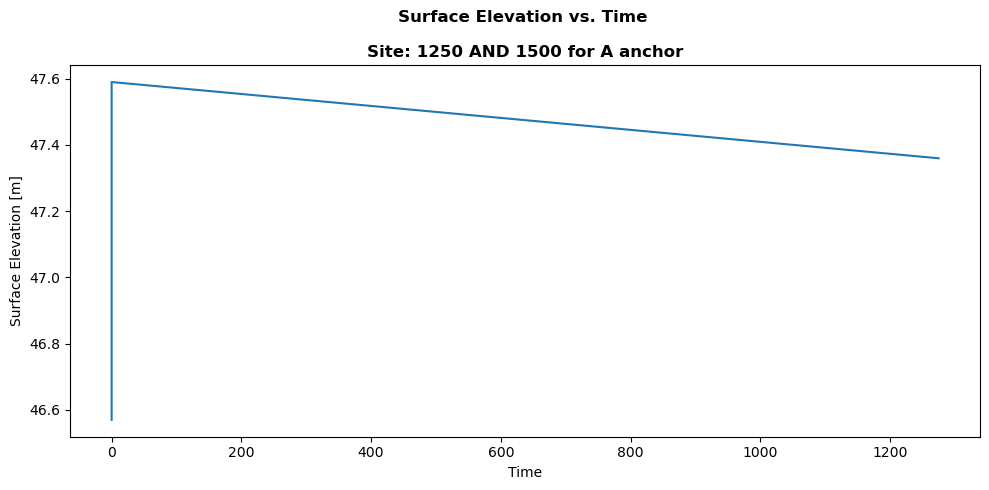

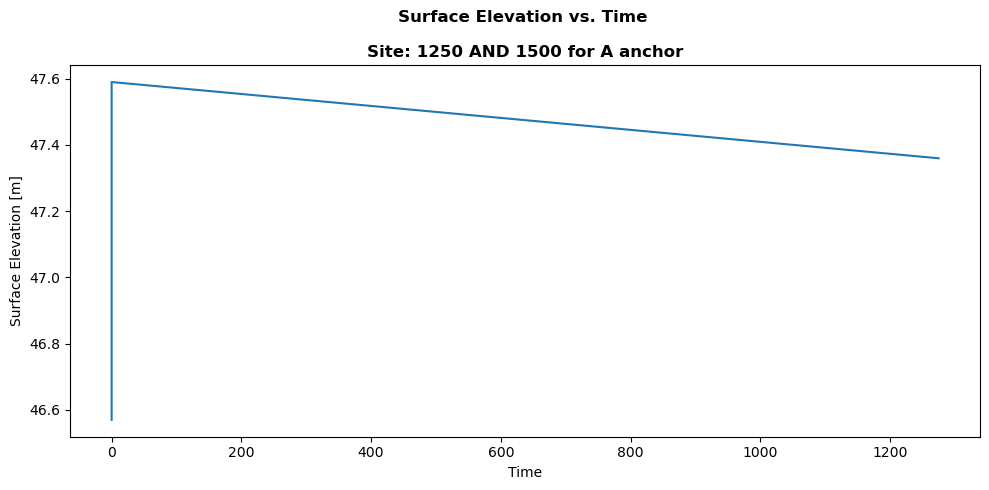

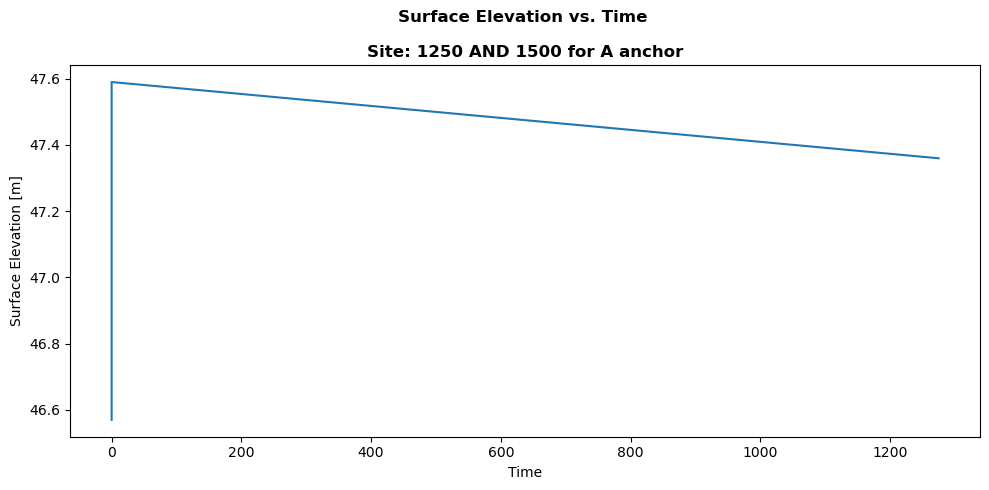

In [48]:
for data in PSDDF_data_list:
    try:
        # Create the figure
        fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (10,5))

        # Plot the Surface Elevation vs. Time plot
        axs.plot(data.file_dfs["psp"]["Time"], data.file_dfs["psp"]["Surface Elev"])
        axs.set_title("Surface Elevation vs. Time \n\nSite: " + data.output_name, fontweight = "bold")
        # label plots
        axs.set_xlabel("Time".format(data.units["t"]))
        axs.set_ylabel("Surface Elevation [{}]".format(data.units["L"]))
        
        # Show plot
        plt.tight_layout()
    except TypeError as te:
        print(te)


#### Plot the Foundation Settlement

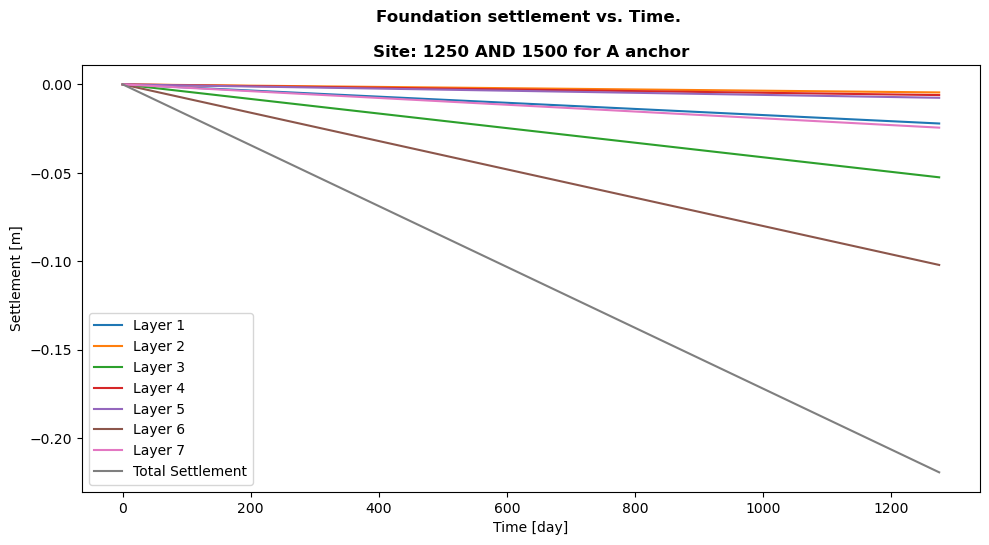

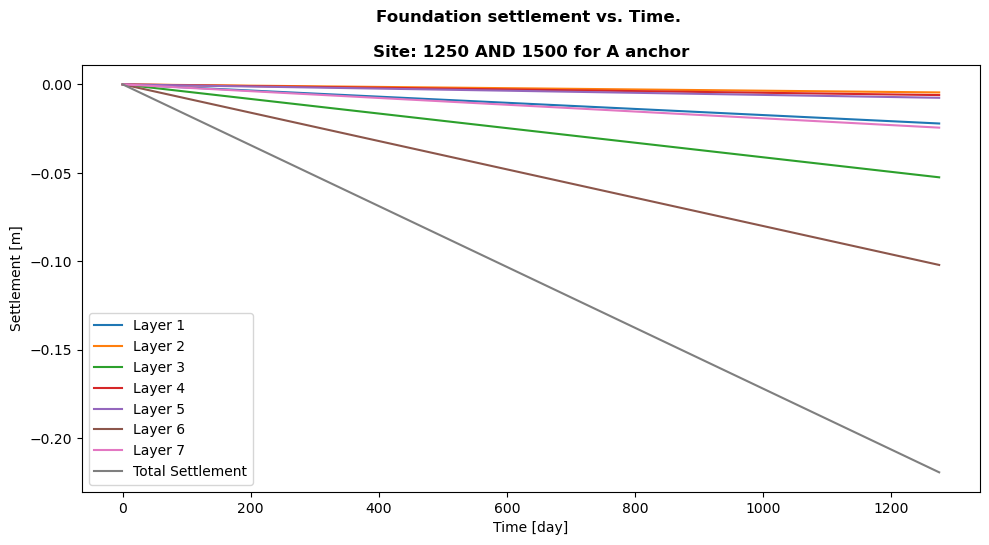

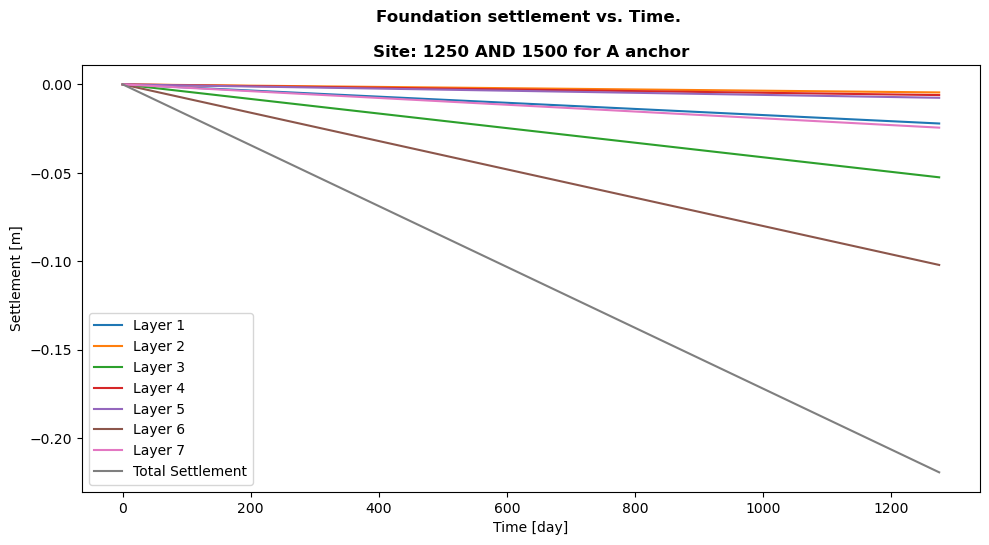

In [49]:
for data in PSDDF_data_list:
    try:
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

        plot_settlement(data, field_data = False, field_data_type = "Settlement", layers = "All", plot_total = True, ax = axs, legend = True, file_type = "pgc", hold_on = False)
        axs.set_title("Foundation settlement vs. Time. \n\nSite: " + data.output_name, fontweight = "bold")
        plt.show()
        
    except TypeError as te:
        print(te)

#### Plot the dredge fill settlement

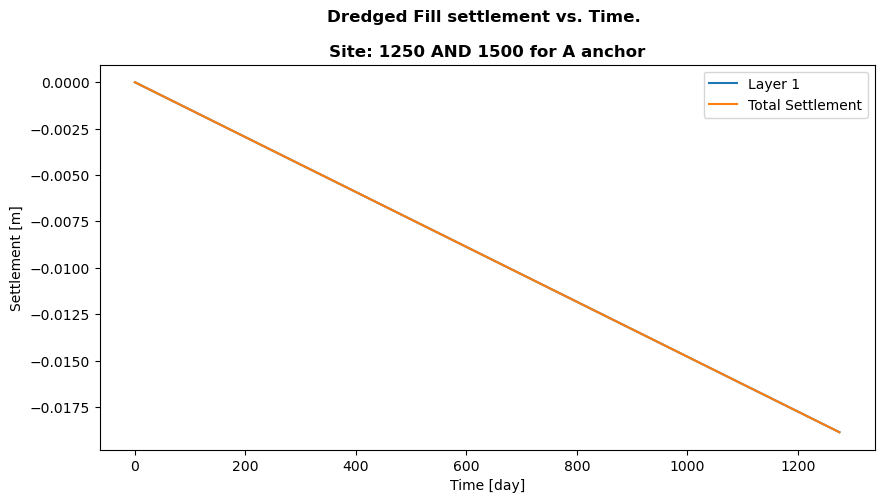

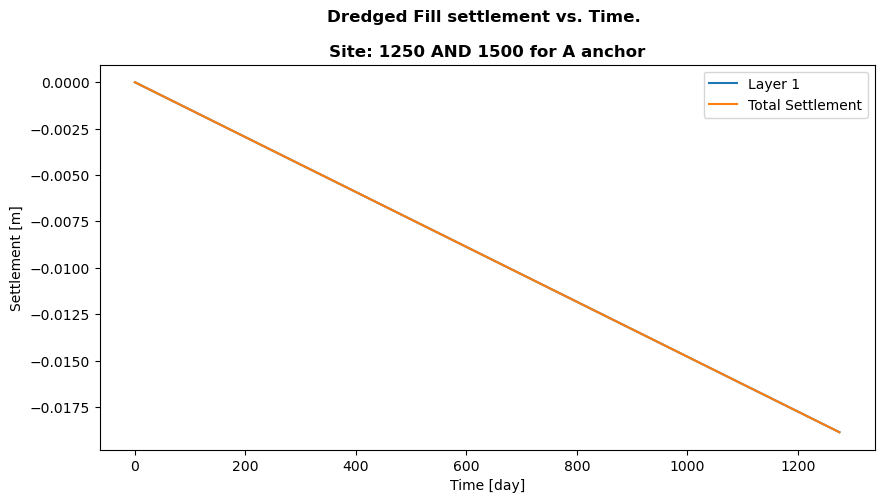

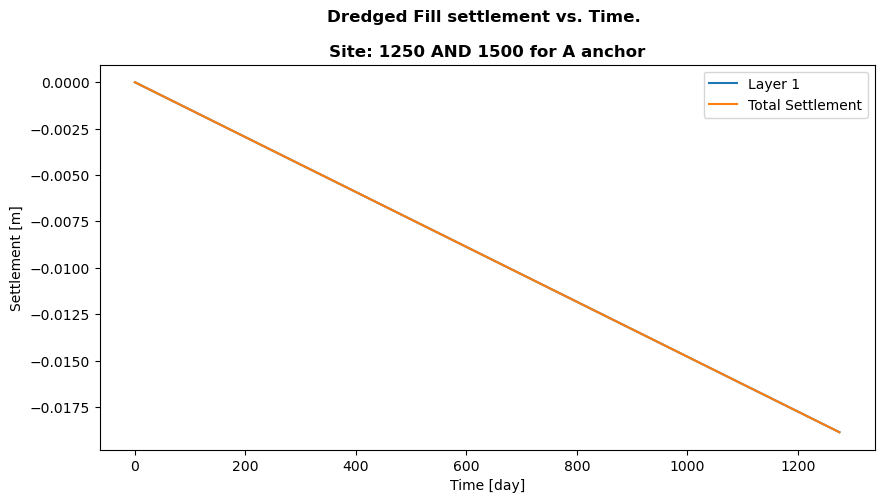

In [50]:
for data in PSDDF_data_list:
    try:
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

        plot_settlement(data, field_data = False, field_data_type = "Settlement", layers = "All", plot_total = True, ax = axs, legend = True, file_type = "pgd", hold_on = True)
        axs.set_title("Dredged Fill settlement vs. Time. \n\nSite: " + data.output_name, fontweight = "bold")
        plt.show()
        
    except TypeError as te:
        print(te)

#### Plot the Foundation Effective stress data

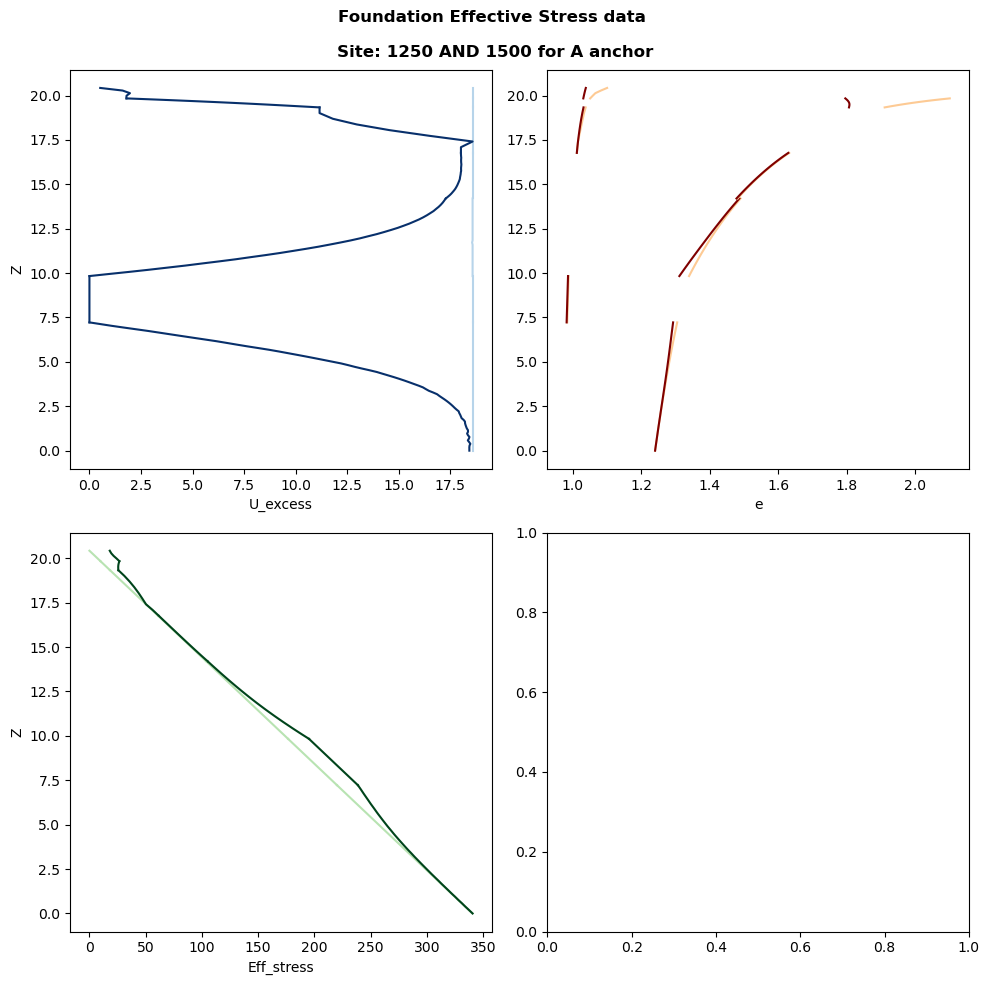

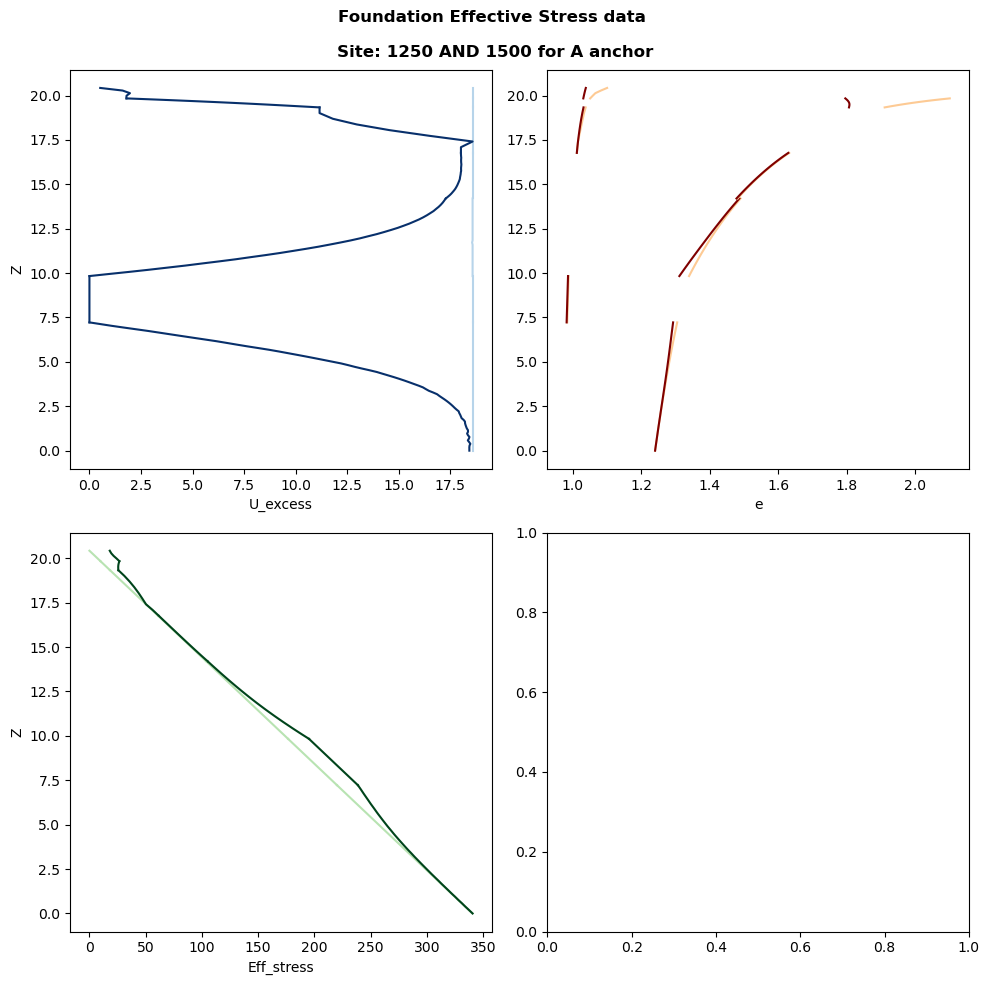

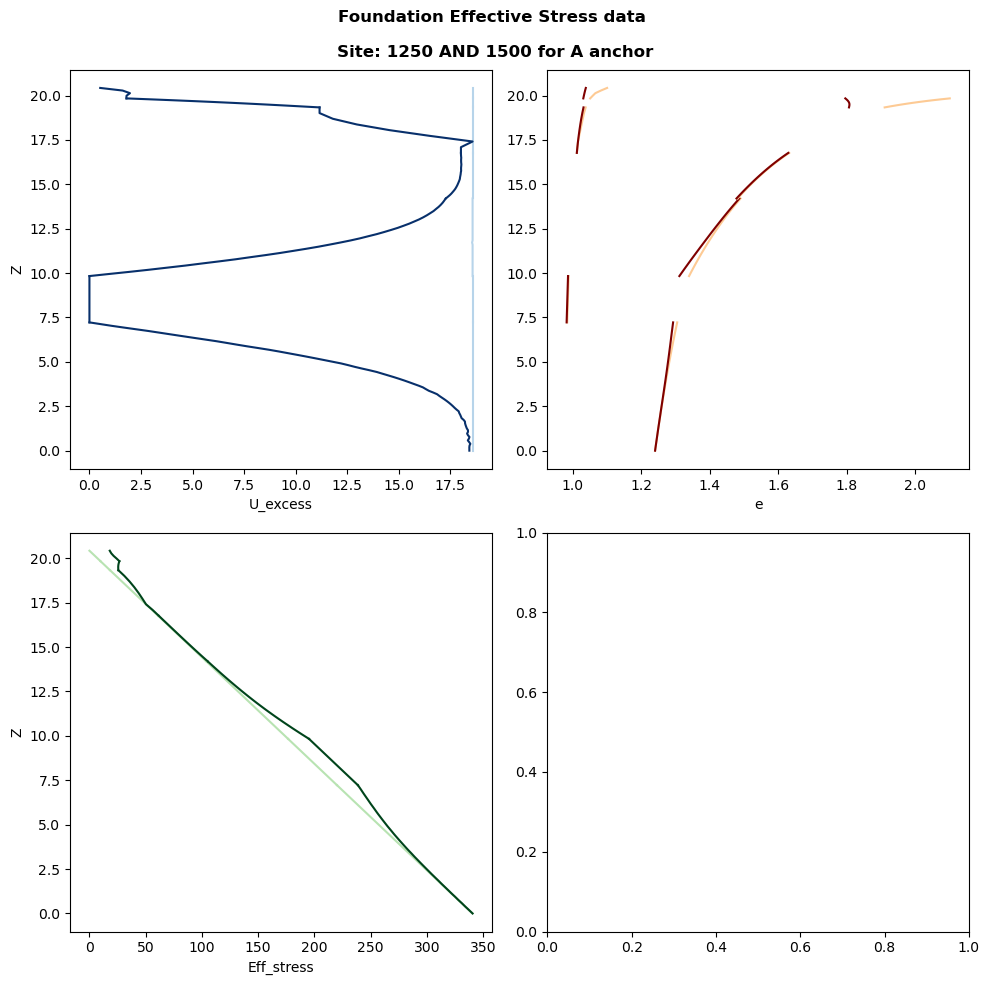

In [51]:
for data in PSDDF_data_list:
    try:
        # Get the unique times that layer 1 existed for 
        Lay1_times = data.layer_dfs["pgc"][0]["Time"].unique()

        figure, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))

        plot_Layer_data(data, ["U_excess", "e", "Eff_stress"], ["Z", "Z", "Z"], fig = figure, layers = "All", times = Lay1_times, legend = False, 
                        file_type = "pgc", leg_loc = "best", set_xlabel = True, set_ylabel = [1,0,1], hold_on = False, input_cmps = ["Blues", "OrRd", "Greens"])
        
        # Create title for all plots
        plt.suptitle("Foundation Effective Stress data \n\nSite: " + data.output_name, fontweight = "bold")
        plt.tight_layout()

    except TypeError as te:
        print(te)


#### Plot the dredged fill effective stress plots

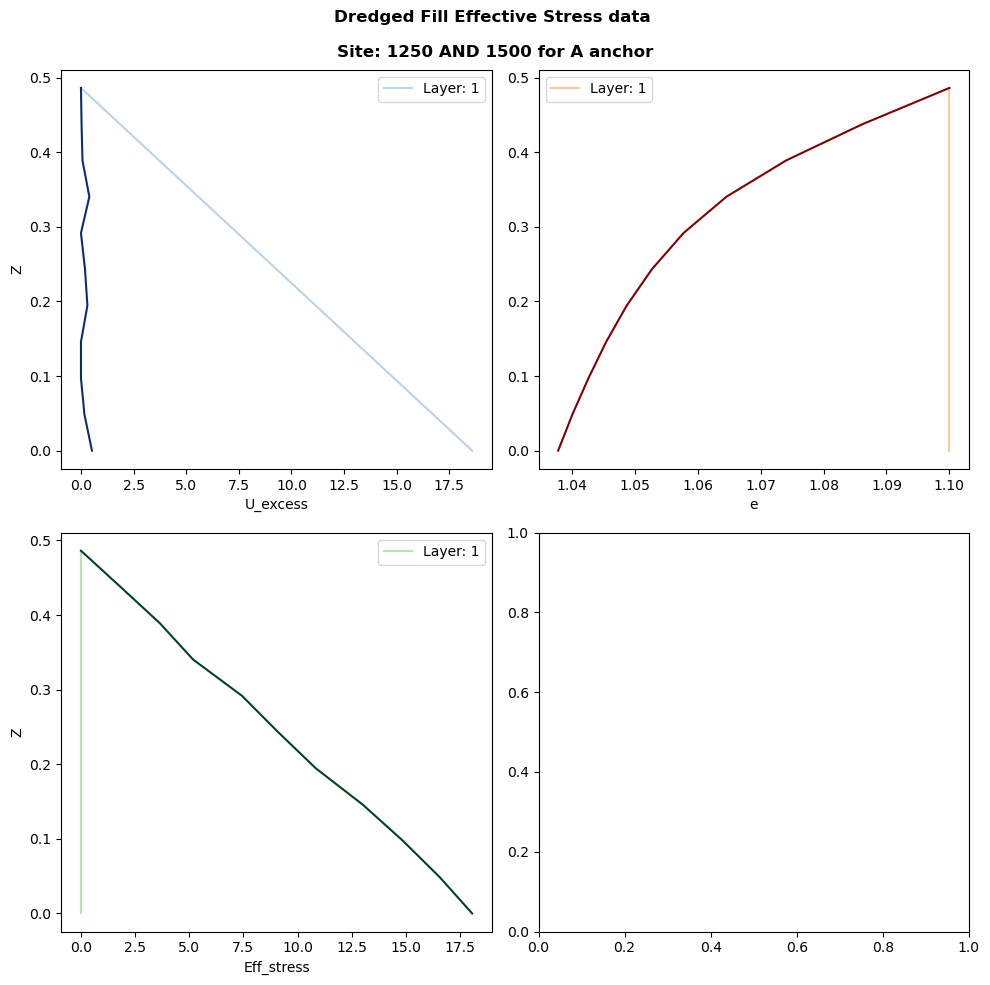

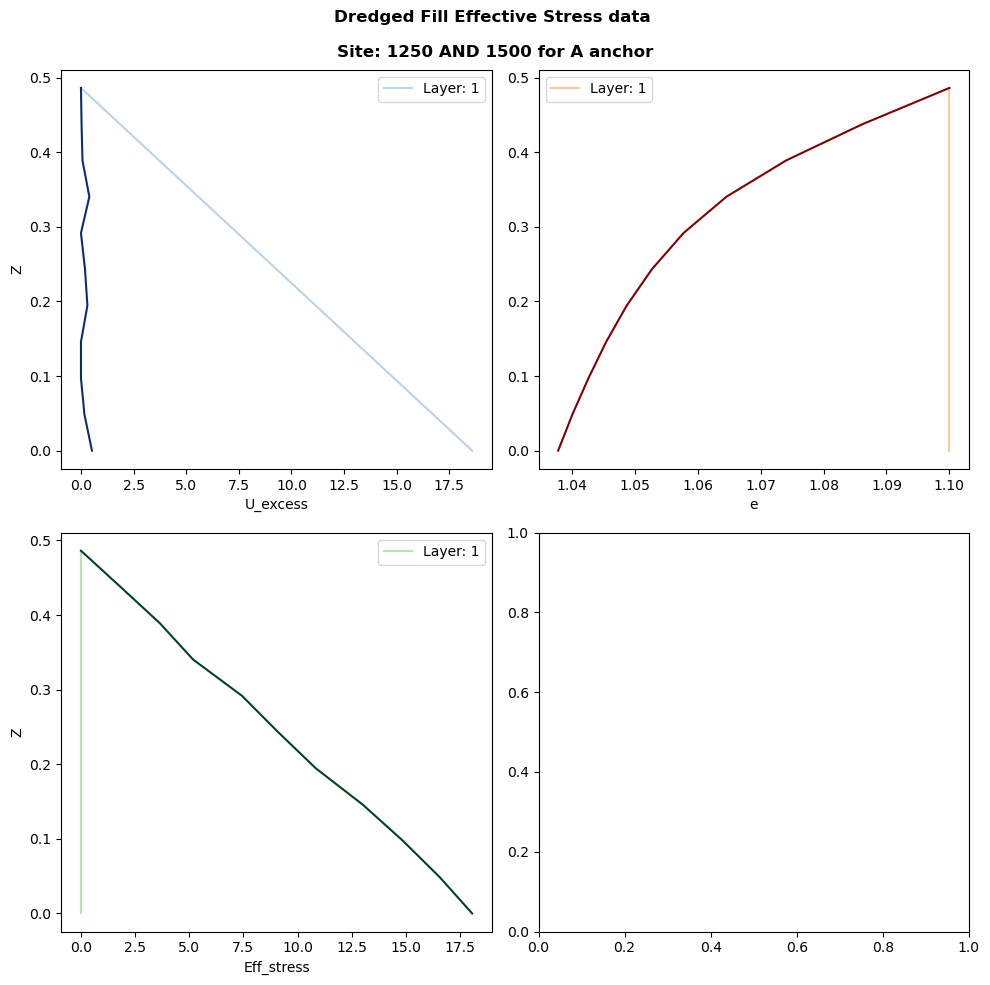

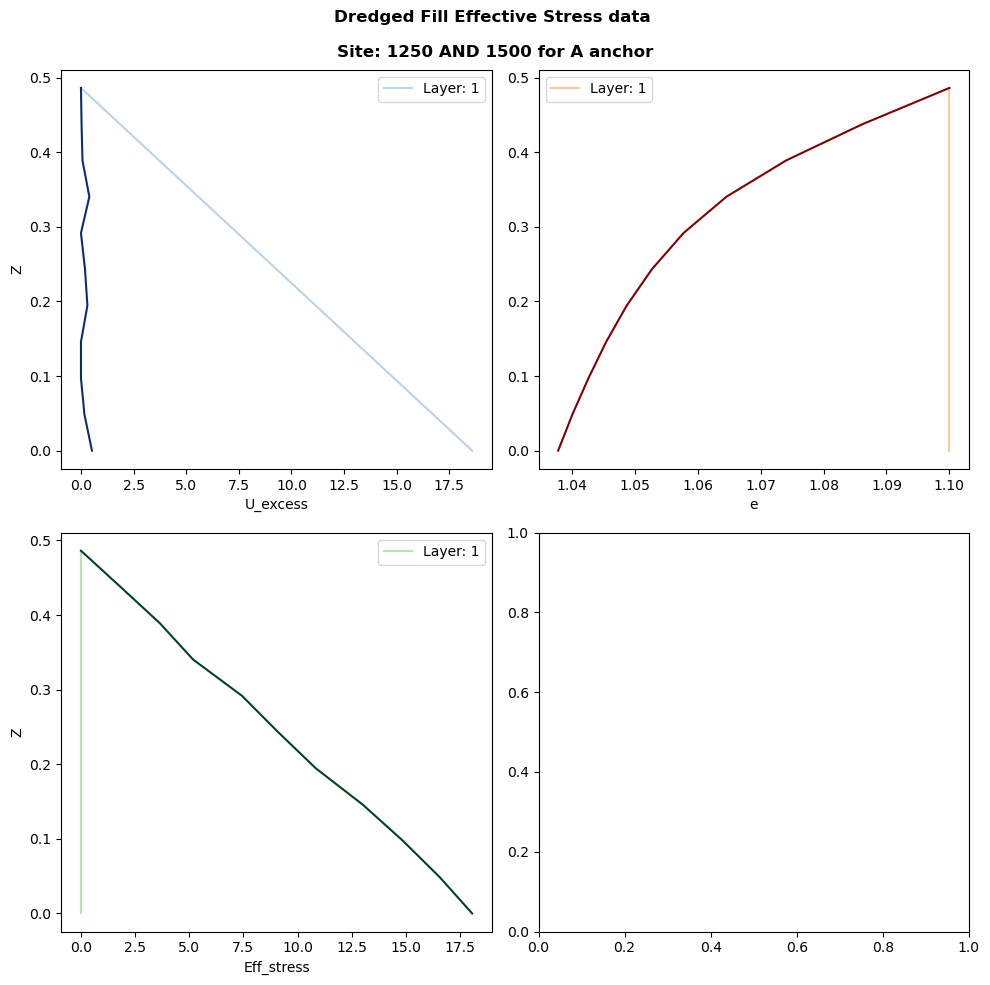

In [52]:
for data in PSDDF_data_list:
    try:
        # Get the unique times that layer 1 existed for 
        Lay1_times = data.layer_dfs["pgd"][0]["Time"].unique()

        figure, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))

        plot_Layer_data(data, ["U_excess", "e", "Eff_stress"], ["Z", "Z", "Z"], fig = figure, layers = "All", times = Lay1_times, legend = True, 
                        file_type = "pgd", leg_loc = "best", set_xlabel = True, set_ylabel = [1,0,1], hold_on = True, input_cmps = ["Blues", "OrRd", "Greens"])
        
        # create title for all plots
        plt.suptitle("Dredged Fill Effective Stress data \n\nSite: " + data.output_name, fontweight = "bold")
        plt.tight_layout()
    
    except TypeError as te:
        print(te)
